# Neural Style Transfer
Use deep learning to compose images in the style of another image

Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

## Import module

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras import models 

sns.set_style('darkgrid')

In [3]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [4]:
os.listdir("../input")

['content2.jpg', 'style2.jpg', 'style1.jpg', 'content1.jpg']

In [5]:
content_path = '../input/content1.jpg'
style_path = '../input/style1.jpg'

height = 480
width = 640

In [6]:
def load_img(location):
    
    img = cv2.resize(cv2.cvtColor(cv2.imread(location), cv2.COLOR_BGR2RGB), (width, height))
    img = np.expand_dims(img, axis = 0).astype('uint8')
    
    return img

In [7]:

def imshow(img, title = ""):
    
    if img.ndim == 4:
        img = np.squeeze(img, axis = 0).astype(np.uint8)
        
    plt.imshow(img)
    
    if title != "":
        plt.title(title)
    plt.xticks([])
    plt.yticks([])


## Visualize the inputs

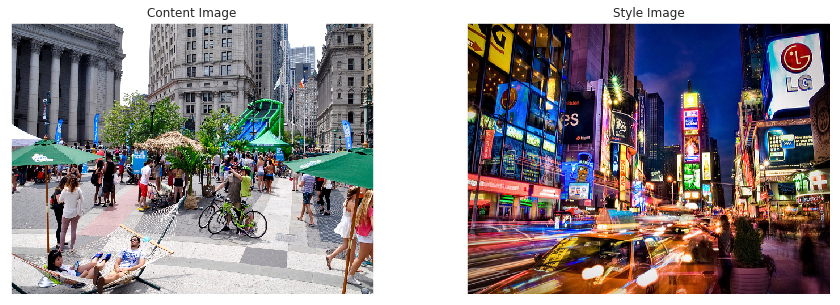

In [8]:
content = load_img(content_path)
style = load_img(style_path)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')

plt.show()

In [9]:
def load_and_process_img(location):
    
    img = load_img(location)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img

In [10]:
def deprocess_img(processed_img):
    
    x = processed_img.copy()
    
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
        
    assert len(x.shape) == 3
    
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

## Define content and style representation

In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def get_model():

    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    
    model_outputs = style_outputs + content_outputs

    return models.Model(vgg.input, model_outputs)

## Define and create our loss functions 

#### Computing content loss

In [13]:
def get_content_loss(base_content, target):
    
      return tf.reduce_mean(tf.square(base_content - target))

#### Computing style loss

In [14]:
def gram_matrix(input_tensor):
    
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    
    return gram / tf.cast(n, tf.float32)

In [15]:
def get_style_loss(base_style, gram_target):

    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))

## Get feature representations

In [16]:
def get_feature_representations(model, content_path, style_path):
    
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features

## Compute loss

In [17]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score 
    
    return loss, style_score, content_score

## Compute gradients

In [18]:
def compute_grads(cfg):
    
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
        
    total_loss = all_loss[0]
    
    return tape.gradient(total_loss, cfg['init_image']), all_loss

## Optimize

In [19]:
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2): 

    model = get_model() 

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    loss_weights = (style_weight, content_weight)
    
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }

    display_interval = 100

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    best_loss, best_img = float('inf'), None
    total_loss_hist, style_score_hist, content_score_hist = [], [], []
    
    
    print('\n\nOPTIMIZATION STARTED\n')
    print('-' * 70)
    
    for i in range(1, num_iterations+1):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
    
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            total_loss_hist.append(loss)
            style_score_hist.append(style_score)
            content_score_hist.append(content_score)
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, style loss: {:.4e}, content loss: {:.4e}'.format(loss, style_score, content_score))
    
    print('-' * 70)
    print('\nOPTIMIZATION FINISHED')
    
    total_loss_hist = np.array(total_loss_hist)
    style_score_hist = np.array(style_score_hist)
    content_score_hist = np.array(content_score_hist)

    return best_img, total_loss_hist, style_score_hist, content_score_hist

In [20]:
best, total_loss_hist, style_score_hist, content_score_hist = run_style_transfer(content_path, style_path, num_iterations=2500)

80142336/80134624 [==============================] - 2s 0us/step


OPTIMIZATION STARTED

----------------------------------------------------------------------
Iteration: 100
Total loss: 1.0969e+07, style loss: 7.3102e+06, content loss: 3.6584e+06
Iteration: 200
Total loss: 5.8492e+06, style loss: 3.2293e+06, content loss: 2.6199e+06
Iteration: 300
Total loss: 3.9609e+06, style loss: 1.9929e+06, content loss: 1.9680e+06
Iteration: 400
Total loss: 3.0760e+06, style loss: 1.4867e+06, content loss: 1.5893e+06
Iteration: 500
Total loss: 2.5885e+06, style loss: 1.2260e+06, content loss: 1.3625e+06
Iteration: 600
Total loss: 2.2898e+06, style loss: 1.0662e+06, content loss: 1.2236e+06
Iteration: 700
Total loss: 2.0910e+06, style loss: 9.6486e+05, content loss: 1.1262e+06
Iteration: 800
Total loss: 1.9499e+06, style loss: 8.9448e+05, content loss: 1.0555e+06
Iteration: 900
Total loss: 1.8424e+06, style loss: 8.4123e+05, content loss: 1.0011e+06
Iteration: 1000
Total loss: 1.7574e+06, style lo

## Visualize the relative change in total loss , content score and style score

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))
total_loss_hist_scaled = scaler.fit_transform(np.expand_dims(total_loss_hist, 1))
style_score_hist_scaled = scaler.fit_transform(np.expand_dims(style_score_hist, 1))
content_score_hist_scaled = scaler.fit_transform(np.expand_dims(content_score_hist, 1))

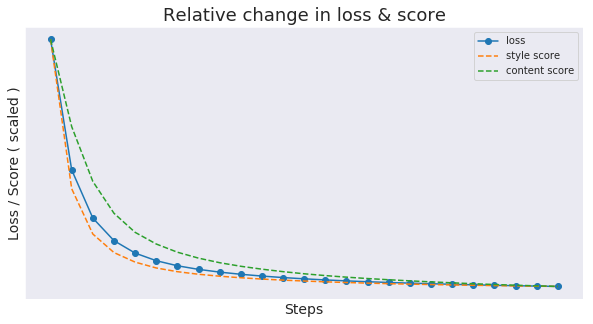

In [22]:
plt.figure(figsize=(10,5))
plt.plot(list(range(len(total_loss_hist))), total_loss_hist_scaled, 'o-', label = 'loss')
plt.plot(list(range(len(style_score_hist))), style_score_hist_scaled, '--', label = 'style score')
plt.plot(list(range(len(content_score_hist))), content_score_hist_scaled, '--', label = 'content score')
plt.xticks([])
plt.yticks([])
plt.title("Relative change in loss & score", fontsize=18)
plt.ylabel('Loss / Score ( scaled )', fontsize=14)
plt.xlabel('Steps', fontsize=14)
plt.legend()
plt.show()

## Visualize results

In [23]:
def show_results(best_img, content_path, style_path):

    content = load_img(content_path) 
    style = load_img(style_path)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    plt.figure(figsize=(12, 10))
    imshow(best_img, 'Output Image')
    
    plt.show()

In [ ]:
show_results(best, content_path, style_path)